## Bus Arrival Time Prediction and Real Time Updating 
##### Group 27

##### Running time Prediction Model with Points of interest data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bus-arrival-time-prediction/bus_running_time_all_features.csv


In [2]:
# import libraries

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# read the dataset - running times
running_time_data = pd.read_csv('/kaggle/input/bus-arrival-time-prediction/bus_running_time_all_features.csv')

In [4]:
running_time_data.head()

,Unnamed: 0.1,Unnamed: 0,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,...,place_of_worship,place_of_education,hospital,tourist_attractions,commercial_places,public_places,nearby_bus_stops,fuel_station,total_poi_count,average_poi_distance
0,0,0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,...,10,2,0,48,3,13,4,1,16,0.002356
1,1,1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,...,8,13,2,35,1,11,1,0,19,0.006437
2,2,2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,...,9,11,2,15,0,2,0,1,13,0.003714
3,3,3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,...,6,3,0,5,0,2,0,1,7,0.007617
4,4,4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,...,4,1,0,1,0,3,0,1,6,0.003597


In [5]:
running_time_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'deviceid', 'direction',
       'segment', 'date', 'start_time', 'end_time', 'run_time',
       'run_time_in_seconds', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'conditions', 'dt(n-1)', 'max_elevation', 'avg_elevation',
       'segment_gradient_average', 'stop_to_stop_gradient',
       'significant_bend_count', 'place_of_worship', 'place_of_education',
       'hospital', 'tourist_attractions', 'commercial_places', 'public_places',
       'nearby_bus_stops', 'fuel_station', 'total_poi_count',
       'average_poi_distance'],
      dtype='object')

In [6]:
features = ['deviceid','week_no','day_of_week','time_of_day','Sunday/holiday','saturday','segment','length','precip','temp',
            'rt(n-1)','rt(n-2)', 'rt(n-3)','rt(t-1)', 'rt(t-2)', 'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'dt(n-1)','run_time_in_seconds']
run_time_dataset = running_time_data[features]

In [7]:
run_time_dataset.head()

,deviceid,week_no,day_of_week,time_of_day,Sunday/holiday,saturday,segment,length,precip,temp,rt(n-1),rt(n-2),rt(n-3),rt(t-1),rt(t-2),rt(w-1),rt(w-2),rt(w-3),dt(n-1),run_time_in_seconds
0,262.0,1.0,4.0,6.50,0.0,0,1.0,0.6261,0.0,20.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,0.0,69.0
1,262.0,1.0,4.0,6.50,0.0,0,2.0,1.2808,0.0,20.0,69.0,247.0,247.0,247.0,247.0,247.0,247.0,247.0,74.0,210.0
2,262.0,1.0,4.0,6.75,0.0,0,3.0,2.1125,0.0,20.0,210.0,69.0,506.0,506.0,506.0,506.0,506.0,506.0,0.0,496.0
3,262.0,1.0,4.0,6.75,0.0,0,4.0,1.5513,0.0,20.0,496.0,210.0,69.0,192.0,192.0,192.0,192.0,192.0,6.0,195.0
4,262.0,1.0,4.0,6.75,0.0,0,5.0,0.8450,0.0,20.0,195.0,496.0,210.0,114.0,114.0,114.0,114.0,114.0,0.0,97.0


In [8]:
print ("No of data points in the dataset : %d \nNo of Features\t: %d"%(run_time_dataset.shape[0],(run_time_dataset.shape[1]-1)))

No of data points in the dataset : 200679 
No of Features	: 19


In [9]:
# Splitting the dataset for training and testing
# In this case we are considering first 36 weeks for training and remaining weeks for testing
X_train_run_time = run_time_dataset[run_time_dataset["week_no"]<=36]
X_test_run_time = run_time_dataset[run_time_dataset["week_no"]>36]
X_test_run_time.reset_index(drop=True,inplace=True)

In [10]:
print ("No of data points in the training set : %d \nNo of data points in the test set : %d"%(X_train_run_time.shape[0],X_test_run_time.shape[0]))

No of data points in the training set : 169329 
No of data points in the test set : 31350


In [11]:
# remove week no
X_train_run_time = X_train_run_time.drop("week_no",axis = 1)
X_test_run_time = X_test_run_time.drop("week_no",axis = 1)


<Axes: >

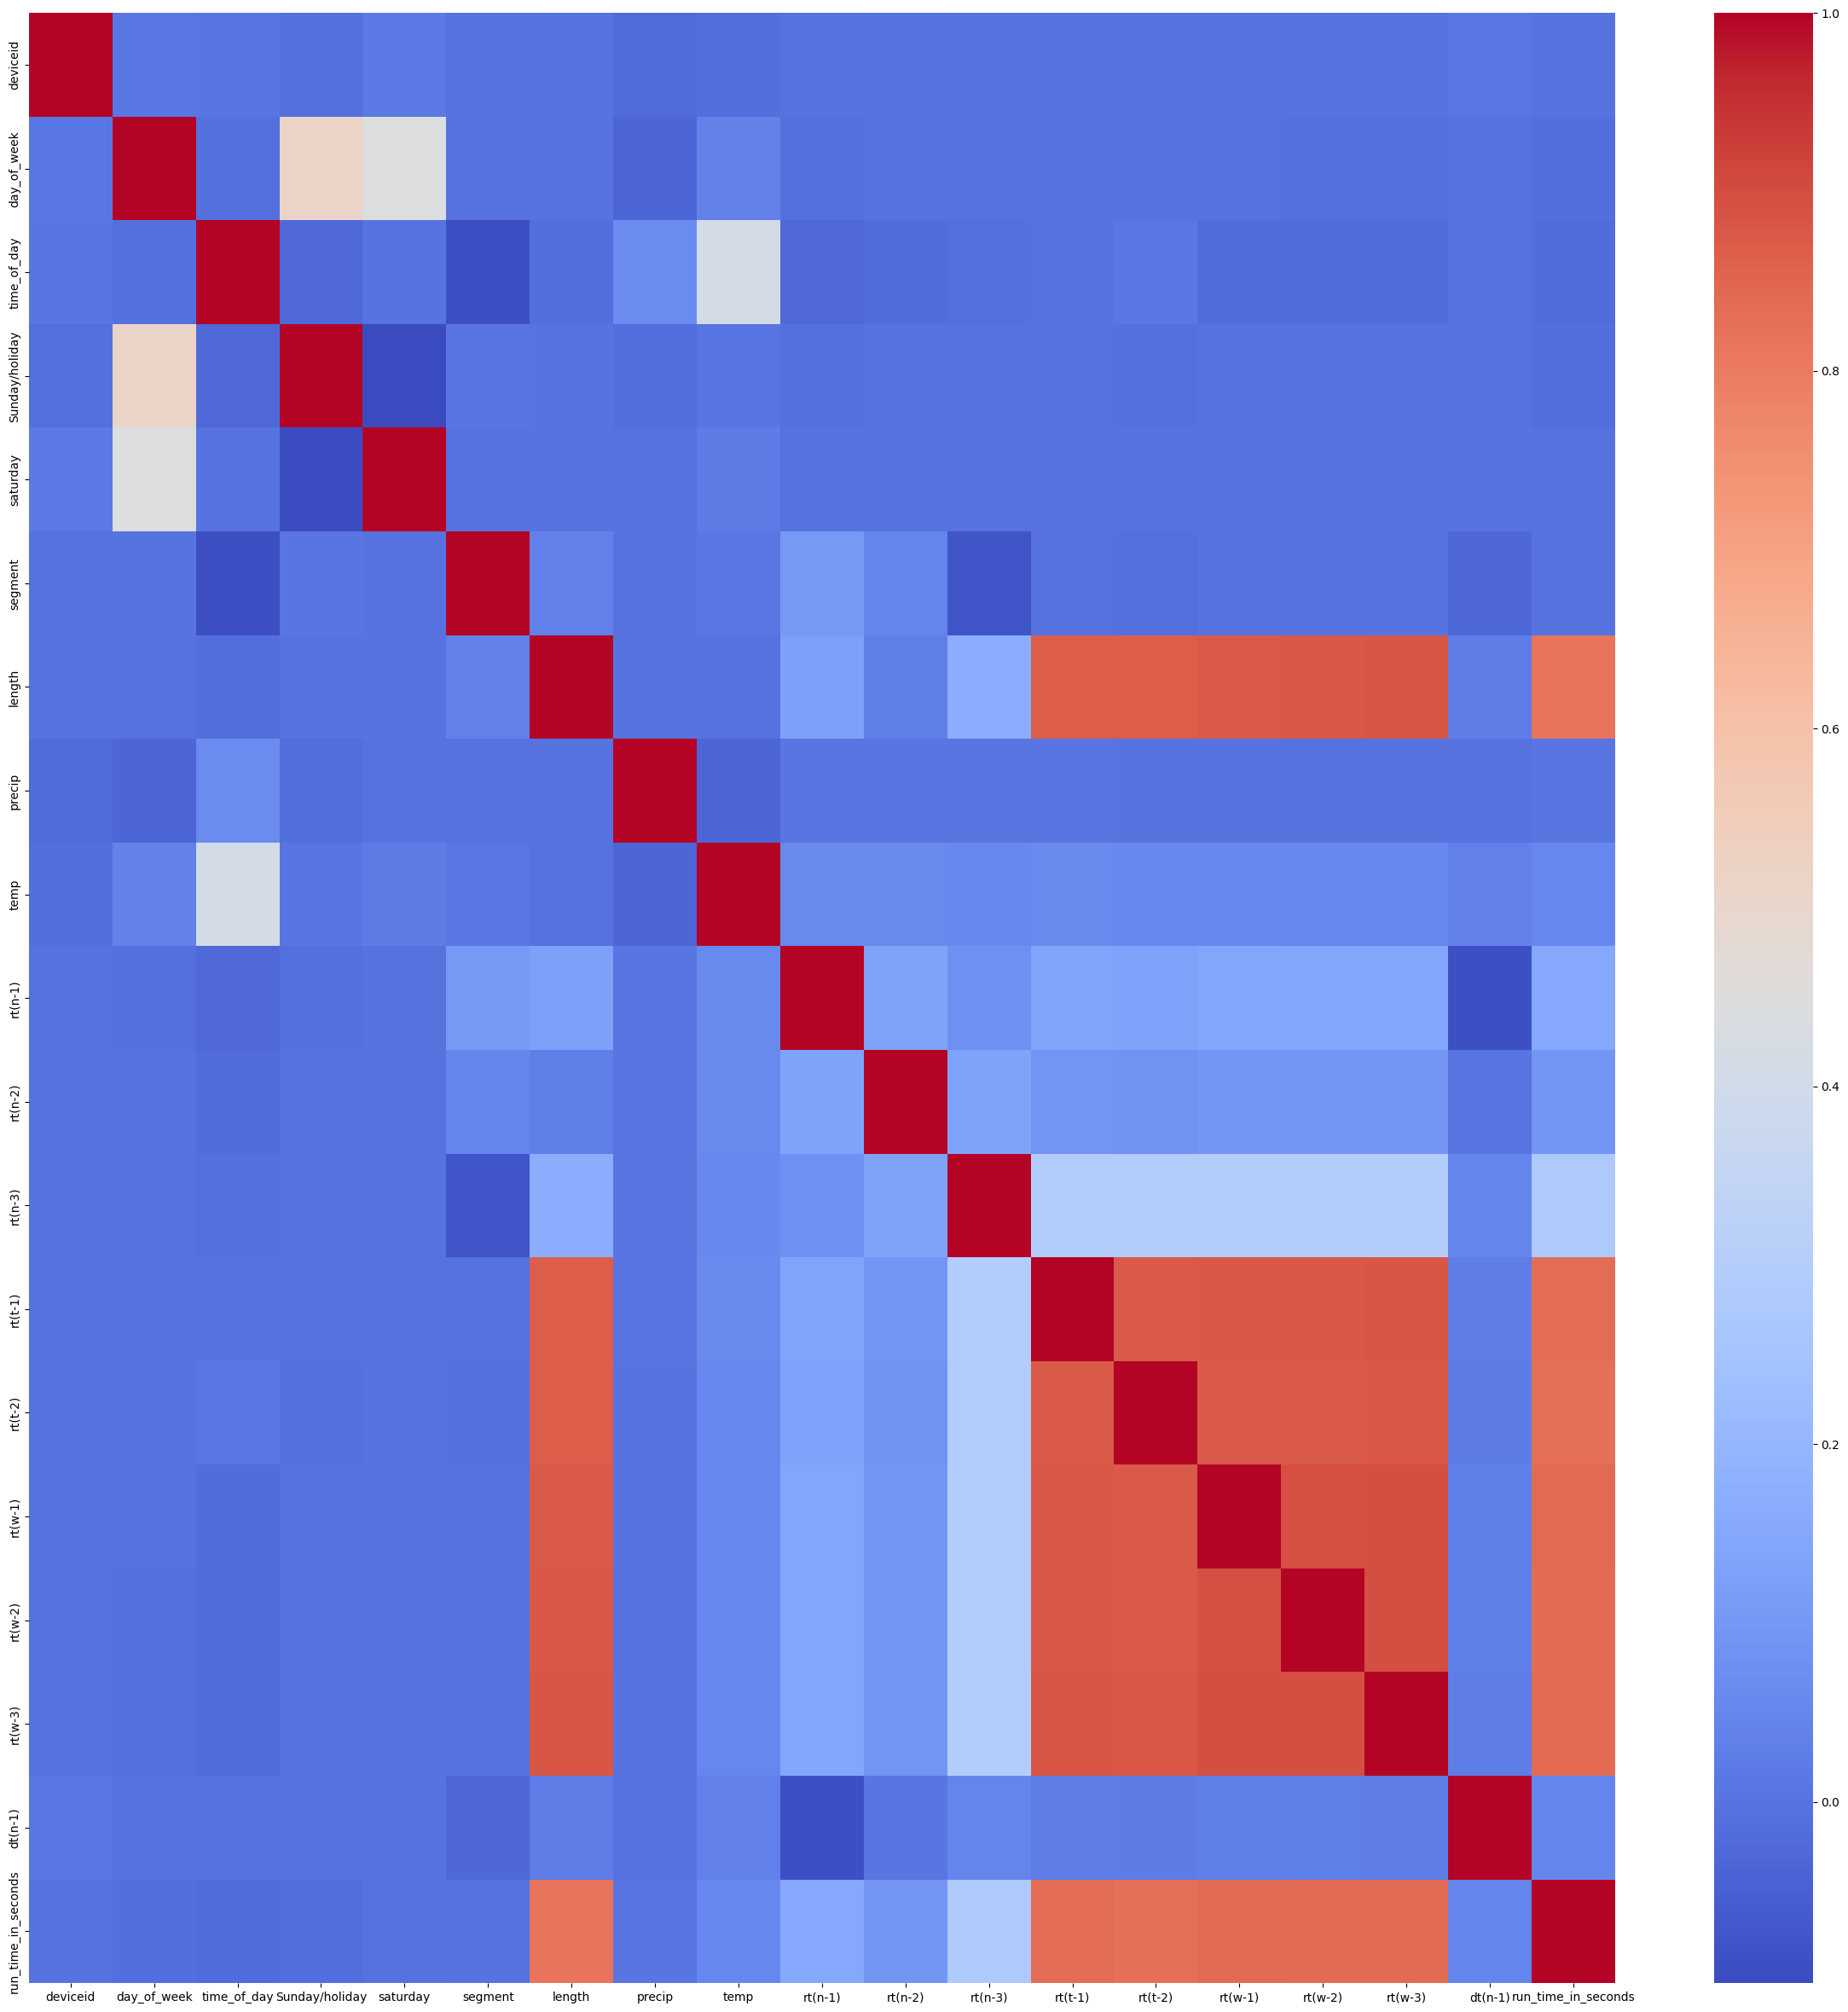

In [12]:
plt.figure(figsize=[30,30])
correlation  = X_train_run_time.corr()
sns.heatmap(data=correlation, cmap = 'coolwarm')

In [13]:
# Get X and Y of train and test
y_train_run_time = X_train_run_time.pop('run_time_in_seconds')
y_test_run_time = X_test_run_time.pop('run_time_in_seconds')

In [14]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train_run_time)
X_train_scaled = scaler.transform(X_train_run_time)
X_test_scaled = scaler.transform(X_test_run_time)

In [15]:
#PCA
pca  = PCA(n_components = 16)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
#Hyperparmeter Grid
parameters = {
    "max_depth": [4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1,0.3],
    "n_estimators": [ 200, 500,600],
    'reg_alpha':[0.001, 0.005, 0.01, 0.05],
    "colsample_bytree": [0.3, 0.6,0.8],
    "random_state":[123],
    "eval_metric":['mape']
    
}

In [17]:
cv_split = TimeSeriesSplit(n_splits=6,max_train_size = 2000, test_size=100)
model = xgb.XGBRegressor()
grid_search_cv = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_cv.fit(X_train_pca, y_train_run_time)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=2000, n_splits=6, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, impo...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.6, 0.8],
                         'eval_metric': ['mape'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [4, 6, 5, 10],
                         'n_estimators': [200, 500, 600], 'random_state': [123],
                         'reg_alpha': [0.001, 0.005, 0.01, 0.05]})

In [18]:
run_time_model = grid_search_cv.best_estimator_
run_time_model.fit(X_train_pca,y_train_run_time)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [19]:
predictions = run_time_model.predict(X_test_pca)
predictions = pd.DataFrame(predictions,columns = ['predicted_running_time_in_seconds'])

In [20]:
predictions.to_csv('predicted_values_initial.csv')

#### Model Evaluation

In [21]:
mse = metrics.mean_squared_error(y_test_run_time,predictions)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test_run_time,predictions)
mape = metrics.mean_absolute_percentage_error(y_test_run_time,predictions)
r2 = metrics.r2_score(y_test_run_time,predictions)

In [22]:
print ("Model Evaluation\n")
print ("Mean Squared Error\t: %f\nRoot Mean Squared Error\t: %f\nMean Absolute Error\t: %f\nMean Absolute Percentage Error\t: %f\nR-Squared\t: %f"%(mse,rmse,mae,mape,r2))

Model Evaluation

Mean Squared Error	: 3311.937036
Root Mean Squared Error	: 57.549431
Mean Absolute Error	: 37.194900
Mean Absolute Percentage Error	: 0.231099
R-Squared	: 0.760347


In [23]:
run_time_model.save_model('run_time_model_initial_v2.json')


### Feature Importance Analysis 

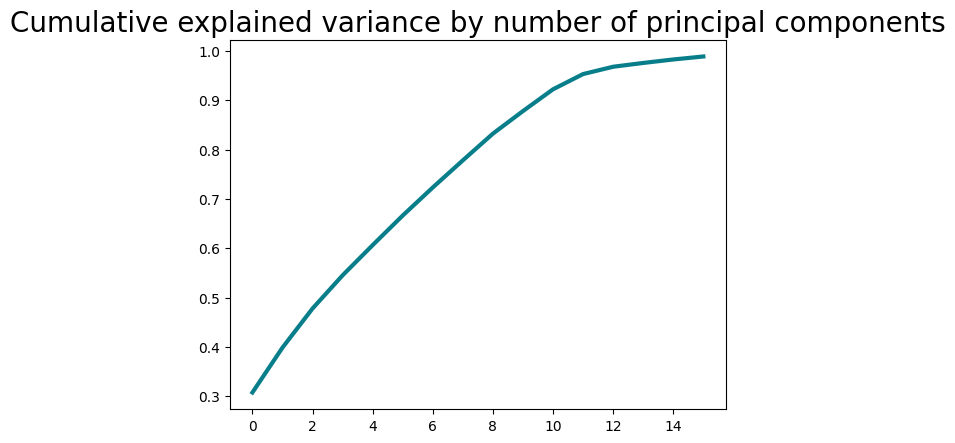

In [24]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [25]:
input_features = ['deviceid','day_of_week','time_of_day','Sunday/holiday','saturday','segment','length','precip','temp',
            'rt(n-1)','rt(n-2)', 'rt(n-3)','rt(t-1)', 'rt(t-2)', 'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'dt(n-1)']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=input_features)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
deviceid,-0.006408,0.018053,0.013444,-0.037283,0.183168,0.065406,-0.526805,-0.722817,0.398818,-0.008012,0.025507,0.021898,0.000744,0.000104,-0.000214,0.001111
day_of_week,-0.008381,0.934728,0.020102,0.002128,0.019605,0.009720,0.034861,-0.003096,0.007968,0.005416,-0.004807,-0.017664,-0.351677,-0.000540,0.000217,0.001214
time_of_day,-0.010175,0.000624,-0.828855,-0.098213,-0.039897,-0.184663,0.024666,-0.063993,0.021642,-0.048072,-0.024511,-0.509163,0.002672,-0.011821,0.002367,0.007849
Sunday/holiday,-0.007973,0.664579,0.088879,-0.002775,-0.675982,-0.009848,-0.013635,-0.090212,0.077677,0.005437,-0.004221,-0.016420,0.280432,0.000343,-0.000337,0.001061
saturday,-0.005783,0.556017,-0.036205,0.001759,0.777195,0.025154,0.099726,0.084622,-0.056954,0.000504,-0.004123,-0.013951,0.253520,-0.001143,-0.000148,0.001210
segment,0.001410,0.005374,0.167646,0.510399,0.034045,-0.365811,-0.193039,0.365073,0.457990,-0.133740,0.407808,-0.108443,-0.000094,0.000771,0.000297,0.010195
length,0.932156,0.008614,0.067057,-0.070674,0.011905,-0.150146,-0.022361,0.024532,0.045585,-0.025282,-0.085241,-0.034566,0.000872,0.007428,-0.010377,-0.265978
precip,-0.000059,-0.069716,-0.068890,-0.027942,0.016067,-0.067471,0.790709,-0.255604,0.530759,0.009632,0.025751,0.108162,-0.009567,-0.000158,-0.001433,-0.000234
temp,0.064931,0.081363,-0.816301,0.125533,-0.050410,-0.071863,-0.154155,0.119512,0.022988,0.016267,0.076452,0.504114,0.008708,0.003183,-0.003731,-0.019161
rt(n-1),0.179972,-0.015530,-0.025852,0.684841,0.005577,-0.036374,0.035068,-0.111585,-0.057302,0.639755,-0.257101,-0.063087,0.000229,0.003516,-0.001074,0.000271


Text(0.5, 1.0, 'Correlation between Original Feature and PCA')

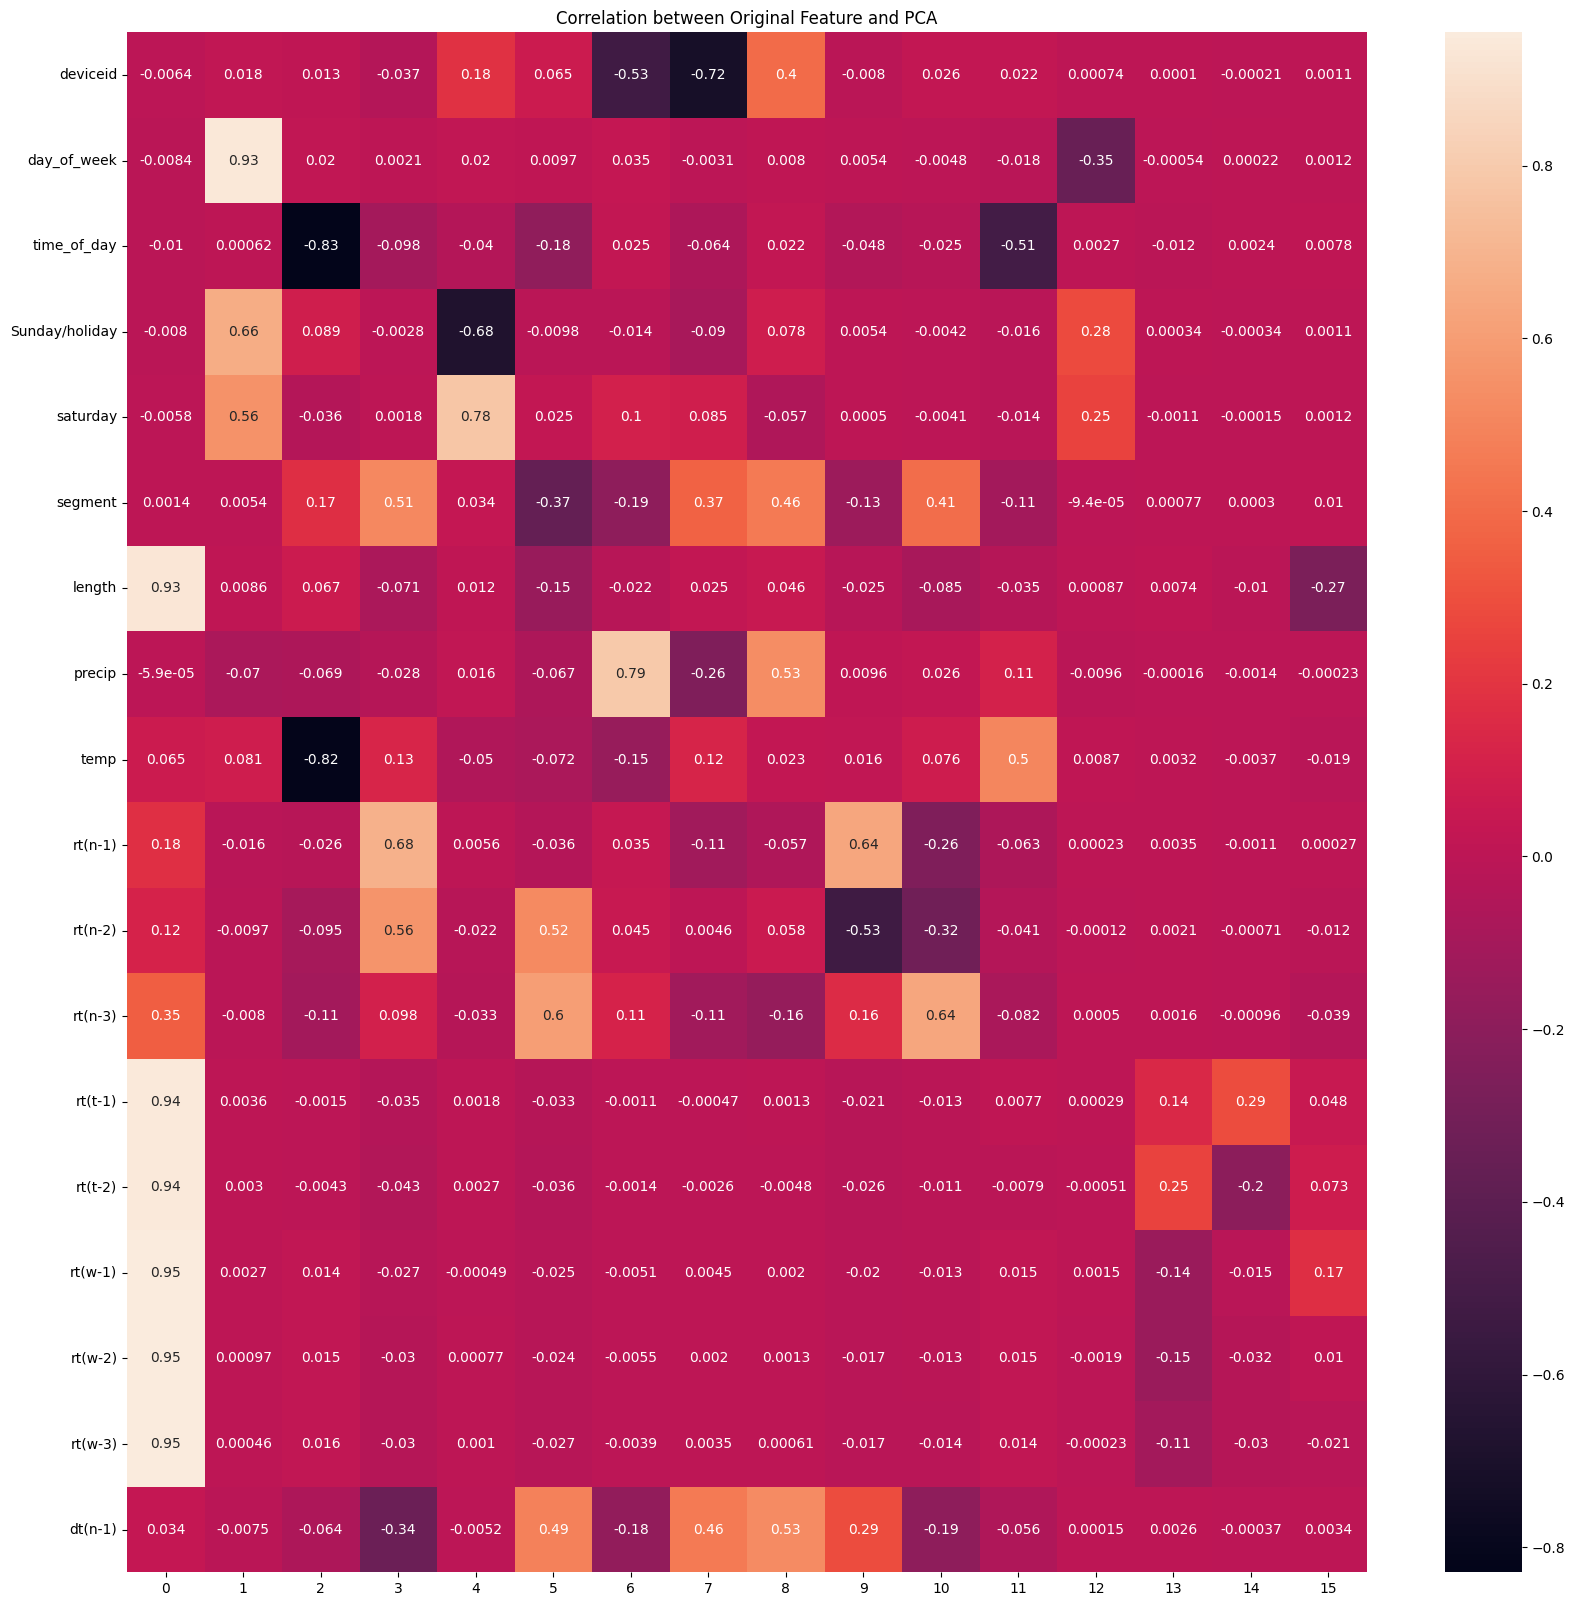

In [26]:
plt.figure(figsize=[20,20])
sns.heatmap(data=loading_matrix,annot=True)
plt.title('Correlation between Original Feature and PCA')

In [27]:
x_importance = X_test_pca
explainer = shap.TreeExplainer(run_time_model)
shap_values = explainer.shap_values(x_importance)

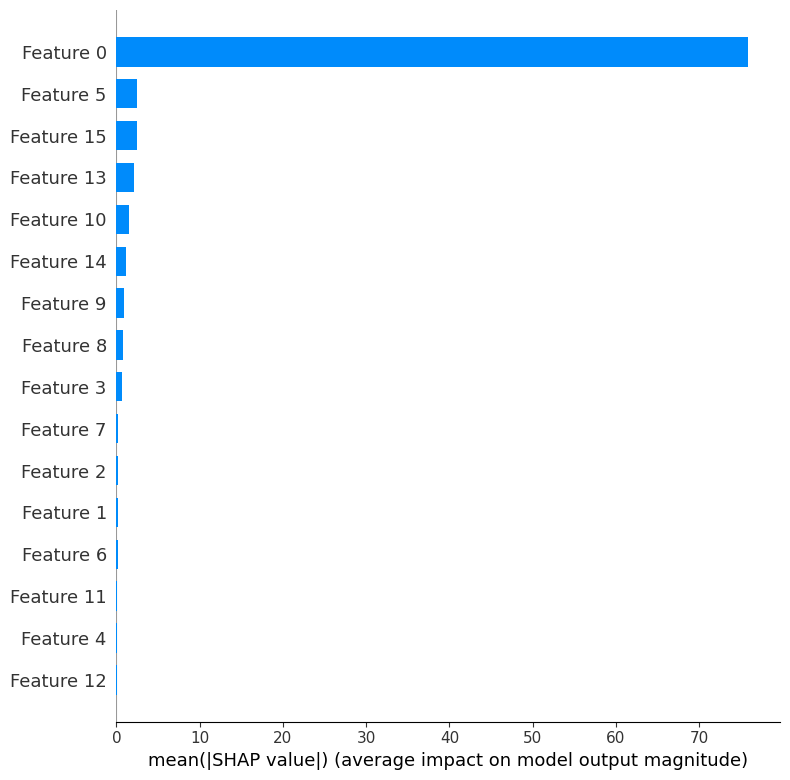

In [28]:
shap.summary_plot(shap_values,x_importance,plot_type="bar")